In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import interp_mnist_utils as imu
import matplotlib.patheffects as patheffects
save_path = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist"


save_dict = torch.load(os.path.join(save_path, "mnist_tsne.pth"),weights_only=False)
print("Saved keys:", save_dict.keys())
print([item.shape for item in save_dict.values()])

Saved keys: dict_keys(['train_tsne', 'test_tsne', 'train_labels', 'test_labels', 'probs_train', 'probs_test', 'prob_map', 'x_vec', 'y_vec'])
[torch.Size([60000, 2]), torch.Size([10000, 2]), torch.Size([60000]), torch.Size([10000]), torch.Size([60000, 10]), torch.Size([10000, 10]), torch.Size([256, 256, 10]), torch.Size([256]), torch.Size([256])]


In [ ]:
import matplotlib.patheffects as patheffects
from mnist_utils import class_density_map
prob_map = save_dict["prob_map"].numpy()
x_vec = save_dict["x_vec"]
y_vec = save_dict["y_vec"]
y = torch.cat([save_dict["train_labels"], save_dict["test_labels"]], dim=0).numpy()
X = torch.cat([save_dict["train_tsne"], save_dict["test_tsne"]], dim=0).numpy()
prob_map, summed_density, x_vec, y_vec = class_density_map(save_dict["train_tsne"],save_dict["train_labels"], std_mult=0.15, max_sidelength=256, truncate=3, square=True)
white_mask = 1/(1+np.exp(38*summed_density[...,None]/summed_density[...,None].max()-4))[:,:,0]
entropy_map = np.sum(-prob_map * np.log(prob_map + 1e-12), axis=2)
entropy_map = (1-white_mask)*entropy_map
#entropy_map = entropy_map>np.quantile(entropy_map, 0.9)
plt.figure(figsize=(12,11))
#plt.imshow(rgb_map, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=0.6, cmap="gray")
plt.imshow(entropy_map, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=1.0, cmap="viridis")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=4, alpha=0.5, cmap="tab10")
plt.title("MNIST t-SNE (PCA→t-SNE)")
for i in range(10):
    digit_mask = (y == i)
    x_mean = X[digit_mask, 0].mean()
    y_mean = X[digit_mask, 1].mean()
    plt.text(x_mean, y_mean, str(i), fontsize=60, fontweight='light',
             color=f'C{i}', ha='center', va='center',
             path_effects=[patheffects.withStroke(linewidth=3, foreground='black')])
plt.tight_layout()
plt.show()


In [59]:
def sample_digit_based(digits, gts, replace=True):
    digit_sample, num = np.unique(digits.flatten(), return_counts=True)
    out_idx = -np.ones(digits.shape)
    for digit,num_sample in zip(digit_sample, num):
        mask = (gts == digit)
        idx = np.random.choice(np.where(mask)[0], size=num_sample, replace=replace)
        out_idx[digits == digit] = idx
    assert (out_idx != -1).all(), "Some digits were not found in gts!"
    return out_idx
neighbourhood = {(0,3): 0.6,
                 (0,5): 1,
                 (0,6): 0.6,
                 (1,2): 1,
                 (1,7): 1,
                 (1,8): 0.3,
                 (2,3): 1,
                 (2,7): 0.3,
                 (2,8): 1,
                 (3,5): 0.6,
                 (3,8): 1,
                 (4,7): 0.6,
                 (4,9): 1,
                 (5,6): 1,
                 (5,8): 1,
                 (5,9): 1,
                 (6,9): 0.6,
                 (7,8): 1,
                 (7,9): 1,
                 (8,9): 1}

n_sample = 20

pairs = list(neighbourhood.keys())
weights = np.array([neighbourhood[pair] for pair in pairs])
weights = weights / weights.sum()
chosen_pairs = np.random.choice(len(pairs), size=n_sample, p=weights, replace=True)
chosen_pairs = np.array([list(pairs[i]) for i in chosen_pairs])
interp_idx = sample_digit_based(chosen_pairs, y)

In [ ]:


tsne_centers_of_interp = np.array([save_dict["class_tsne"][digit] for digit in chosen_pairs.flatten()]).reshape(chosen_pairs.shape + (2,))

prob_map = save_dict["prob_map"].numpy()
x_vec = save_dict["x_vec"]
y_vec = save_dict["y_vec"]
y = torch.cat([save_dict["train_labels"], save_dict["test_labels"]], dim=0).numpy()
X = torch.cat([save_dict["train_tsne"], save_dict["test_tsne"]], dim=0).numpy()

entropy_map = np.sum(-prob_map * np.log(prob_map + 1e-12), axis=2)
plt.figure(figsize=(12,11))
#plt.imshow(rgb_map, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=0.6, cmap="gray")
plt.imshow(entropy_map, extent=(x_vec[0], x_vec[-1], y_vec[0], y_vec[-1]), origin='lower', aspect='auto', alpha=1.0, cmap="viridis")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=4, alpha=0.5, cmap="tab10")
plt.title("MNIST t-SNE (PCA→t-SNE)")
for i in range(10):
    digit_mask = (y == i)
    x_mean = X[digit_mask, 0].mean()
    y_mean = X[digit_mask, 1].mean()
    plt.text(x_mean, y_mean, str(i), fontsize=60, fontweight='light',
             color=f'C{i}', ha='center', va='center',
             path_effects=[patheffects.withStroke(linewidth=3, foreground='black')])
plt.tight_layout()
plt.show()


[1 2 3 4 5 6] [0 1 2 0 1 2 3 4 5] [2 2 2 1 1 1]


In [92]:
X = np.concatenate([save_dict["train_tsne"], save_dict["test_tsne"]], axis=0)
if False:
    p = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist/interp_images_points.npy"
    interp_images = np.load(p, allow_pickle=True).item()

    idx_A = interp_images["test"]["indices_A"]+60000
    idx_B = interp_images["test"]["indices_B"]+60000
    ratio_A = interp_images["test"]["ratio_A"]
else:

    indices = imu.sample_from_vae_latents("train", save_dict["train_labels"],num_samples=100)
    idx_A = indices[:,0]
    idx_B = indices[:,1]
    ratio_A = 0.5*np.ones_like(idx_A)
plt.figure(figsize=(15,15))
a = X[idx_A,0]*ratio_A + X[idx_B,0]*(1-ratio_A)
b = X[idx_A,1]*ratio_A + X[idx_B,1]*(1-ratio_A)
plt.scatter(a,b,s=50,c='red',marker='.',alpha=0.5)
p1 = X[np.c_[idx_A,idx_B],0].flatten()
p2 = X[np.c_[idx_A,idx_B],1].flatten()
#modify to have NANs every third point, [v1,v2,NAN,v1,v2,NAN,...]
p1 = [val for pair in zip(p1[::2], p1[1::2], [np.nan]* (len(p1)//2)) for val in pair]
p2 = [val for pair in zip(p2[::2], p2[1::2], [np.nan]* (len(p2)//2)) for val in pair]
plt.plot(p1,p2,c='k',alpha=0.5, linewidth=1.5)
for i in range(10):
    digit_mask = (y == i)
    x_mean = X[digit_mask, 0].mean()
    y_mean = X[digit_mask, 1].mean()
    plt.text(x_mean, y_mean, str(i), fontsize=60, fontweight='light',
             color=f'C{i}', ha='center', va='center',
             path_effects=[patheffects.withStroke(linewidth=3, foreground='black')])

Sampling Indices from VAE Latents:   0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: Not enough pairs found!

In [32]:
latents = imu.encode_all_mnist()

Encoding MNIST:   0%|          | 0/1094 [00:00<?, ?it/s]

(array([10., 21., 14., 14.,  3.,  1.,  0.,  0.,  0.,  1.]),
 array([0.83515966, 0.96018374, 1.08520794, 1.21023202, 1.3352561 ,
        1.46028018, 1.58530426, 1.71032846, 1.83535254, 1.96037662,
        2.08540082]),
 <BarContainer object of 10 artists>)

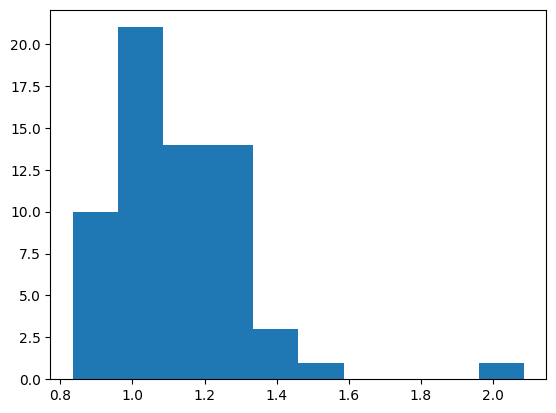

In [52]:
plt.hist(latents.std(0))

In [84]:
X = latents[60000:]
gts = save_dict["test_labels"]
n = 100
from tqdm.auto import tqdm
p = []
for i in tqdm(range(X.shape[0])):
    distances = np.linalg.norm(X - X[i], axis=1)
    idx_sort = np.argsort(distances)
    p.append((gts[idx_sort[:n]]==gts[i]).sum()/n)

  0%|          | 0/10000 [00:00<?, ?it/s]

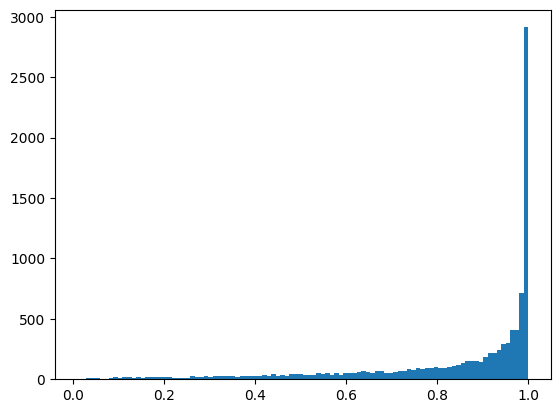

In [87]:
plt.hist(p,100);

In [88]:
np.mean(p)

np.float32(0.84259504)

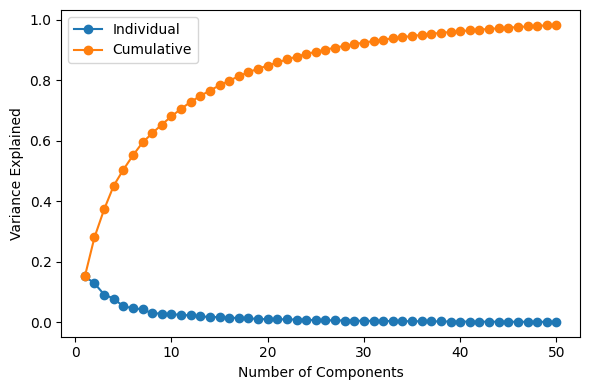

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# X: your data, shape (70000, 64)
# Example placeholder:
# X = np.random.randn(70000, 64)

# Fit PCA
pca = PCA(n_components=50)
pca.fit(latents)

# Variance explained
explained_var = pca.explained_variance_ratio_

# Plot
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, 51), explained_var, marker='o', label='Individual')
plt.plot(np.arange(1, 51), np.cumsum(explained_var), marker='o', label='Cumulative')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.legend()
plt.tight_layout()
plt.show()


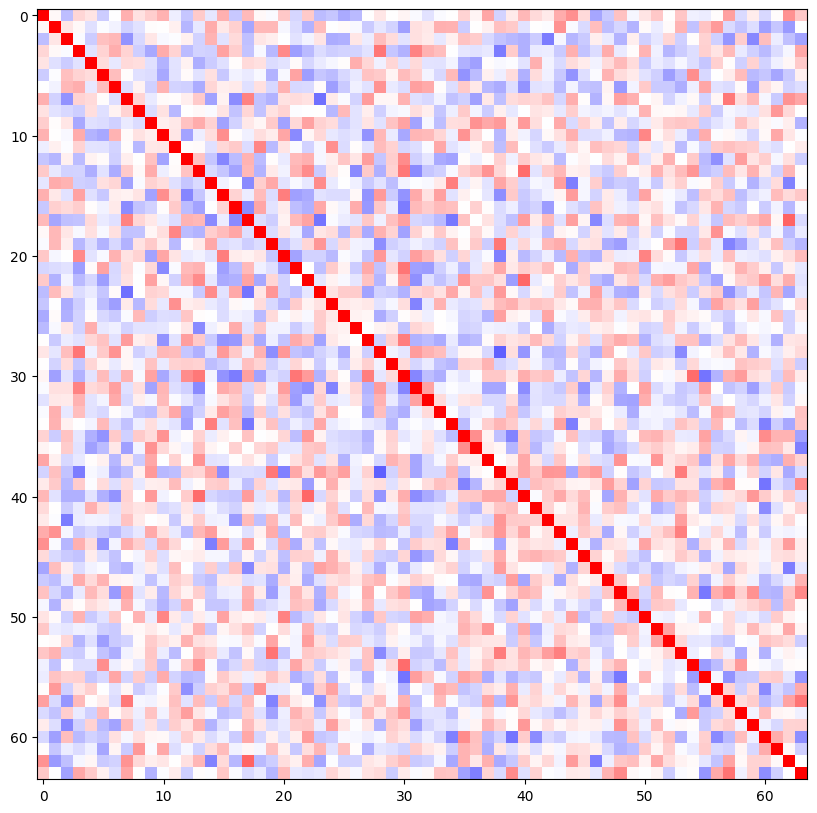

In [ ]:
norm_latents = (latents - latents.mean(0, keepdims=True)) / latents.std(0, keepdims=True)

corr = np.corrcoef(norm_latents, rowvar=False)
plt.figure(figsize=(10,10))
plt.imshow(corr, vmin=-1, vmax=1, cmap="bwr")

#do pca


In [43]:
s.shape

(64,)

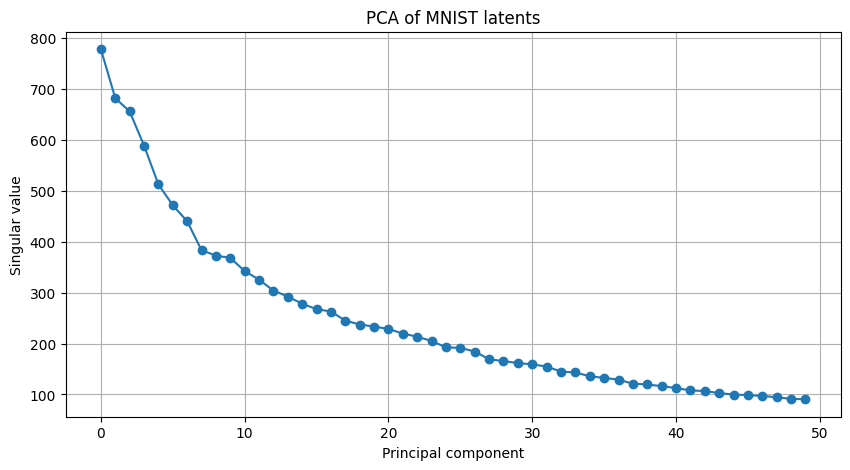

In [46]:
pc, s, v = np.linalg.svd(norm_latents, full_matrices=False)
plt.figure(figsize=(10,5))
plt.plot(s[:50], marker='o')
plt.xlabel("Principal component")
plt.ylabel("Singular value")
plt.title("PCA of MNIST latents")
plt.grid()
plt.show()

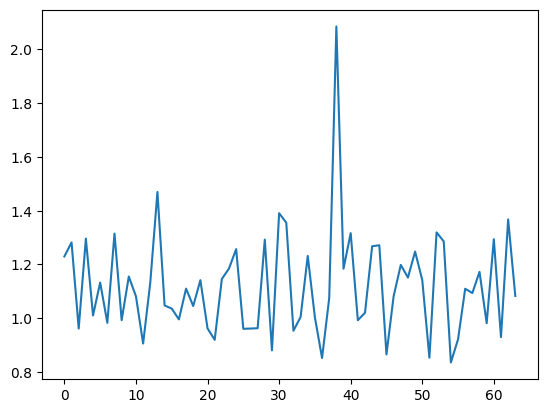

In [40]:
plt.plot(latents.std(0))

In [ ]:
#interp
X_images = imu.get_MNIST_images()
white_im = np.ones((28,28))
big_cat_image = []
for i in range(len(interp_idx[:10])):
    xA_np = X_images[interp_idx[i,0].astype(int)]
    xB_np = X_images[interp_idx[i,1].astype(int)]
    xA = torch.as_tensor(xA_np)[None,None]
    xB = torch.as_tensor(xB_np)[None,None]
    interp = imu.latent_interpolation(xA,xB)
    big_cat_image.append([xA_np]+[white_im]+interp+[white_im]+[xB_np])
big_cat_image = np.concatenate([np.concatenate(row, axis=1) for row in big_cat_image], axis=0)
plt.figure(figsize=(15,15))
plt.imshow(big_cat_image, cmap='gray')

NameError: name 'interp_idx' is not defined

In [113]:
batch_size = 64
n_sample = 200

if False:
    pairs = list(neighbourhood.keys())
    weights = np.array([neighbourhood[pair] for pair in pairs])
    weights = weights / weights.sum()
    chosen_pairs = np.random.choice(len(pairs), size=n_sample, p=weights, replace=True)
    chosen_pairs = np.array([list(pairs[i]) for i in chosen_pairs])
    interp_idx = sample_digit_based(chosen_pairs, y)
    print("Random pairs of neighbouring digit clusters")
elif False:
    interp_idx = np.random.choice(len(X_images), size=(n_sample,2), replace=True)
    print("Random pairs")
elif True:
    interp_idx = sample_from_entropy_map(
        entropy_map, tsne, x_vec, y_vec, gts,
        num_samples=200, gaussian_std=0.15, truncate=3,
        attempt_multiplier=5, tries_per_center=1, rng=None
    )
    print("Smart tsne pairs")
processed = 0
num_batches = int(np.ceil(n_sample / batch_size))
interp_images = []
all_xA = []
all_xB = []
for _ in range(num_batches):
    batch_idx = interp_idx[processed:processed+batch_size]
    xA_batch = torch.as_tensor(X_images[batch_idx[:,0].astype(int)])[:,None]
    xB_batch = torch.as_tensor(X_images[batch_idx[:,1].astype(int)])[:,None]
    all_xA.append(xA_batch)
    all_xB.append(xB_batch)
    processed += batch_size
    interp_images.append(imu.batched_interpolation(xA_batch,xB_batch))

all_xA = torch.cat(all_xA, dim=0).numpy()
all_xB = torch.cat(all_xB, dim=0).numpy()
interp_images = np.concatenate(interp_images, axis=0)
print(all_xA.shape, all_xB.shape, interp_images.shape)  # (n_sample, 1, 28, 28) (n_sample, 1, 28, 28) (n_sample, n_interp, 1, 28, 28)


Smart tsne pairs
(200, 1, 28, 28) (200, 1, 28, 28) (200, 1, 28, 28)


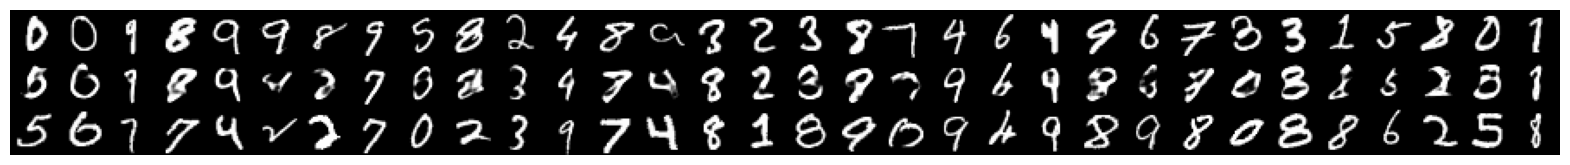

In [127]:
show_idx = np.arange(32)
f = lambda vals: np.clip((vals-0.3)*1.2+0.3,0,1)
all_xA_show = np.concatenate([all_xA[i] for i in show_idx], axis=2).transpose((1,2,0))
all_xB_show = np.concatenate([all_xB[i] for i in show_idx], axis=2).transpose((1,2,0))
interp_show = np.concatenate([interp_images[i] for i in show_idx], axis=2).transpose((1,2,0))
full_show_im = np.concatenate([all_xA_show, f(interp_show), all_xB_show], axis=0)
plt.figure(figsize=(20,20))
plt.imshow(full_show_im, cmap='gray')
plt.axis('off')
plt.show()

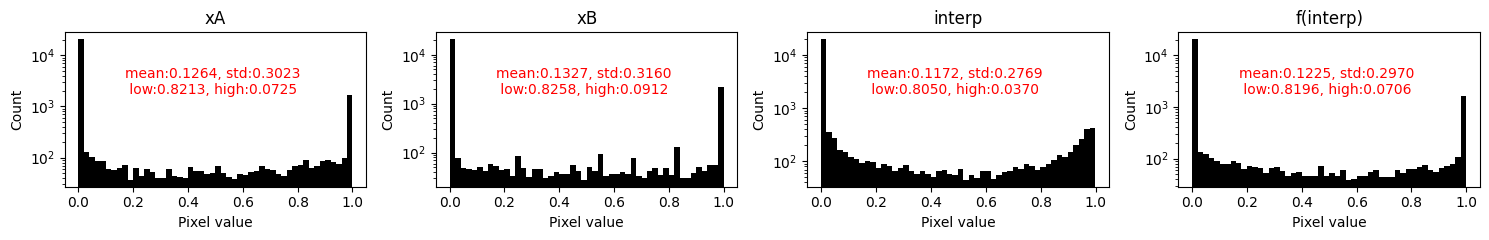

In [134]:
plt.figure(figsize=(15,2.5))
titles = ["xA", "xB", "interp", "f(interp)"]

for i, vals in enumerate([all_xA_show, all_xB_show, interp_show,  f(interp_show)]):
    if i==1:
        vals = np.clip((vals-0.3)*1.2+0.3,0,1)
    plt.subplot(1,len(titles),i+1)
    plt.hist(vals.flatten(), bins=50, color='black')
    plt.yscale('log')
    plt.xlabel("Pixel value")
    plt.ylabel("Count")
    low_vals = (vals<0.05).sum()/vals.size
    high_vals = (vals>0.95).sum()/vals.size
    plt.text(0.2, 0.6,f"mean:{vals.mean():.4f}, std:{vals.std():.4f} \n low:{low_vals:.4f}, high:{high_vals:.4f}", transform=plt.gca().transAxes, color="red")
    plt.title(titles[i])
plt.tight_layout()

In [ ]:



prob_map, summed_density, x_vec, y_vec = class_density_map(save_dict["train_tsne"],save_dict["train_labels"], std_mult=0.15, max_sidelength=256, truncate=3, square=True)
white_mask = 1/(1+np.exp(38*summed_density[...,None]/summed_density[...,None].max()-4))[:,:,0]
entropy_map = np.sum(-prob_map * np.log(prob_map + 1e-12), axis=2)
entropy_map = (1-white_mask)*entropy_map

tsne = torch.cat([save_dict["train_tsne"], save_dict["test_tsne"]], dim=0).numpy()
print(tsne.shape,entropy_map.shape)
def sample_from_entropy_map(entropy_map, tsne, x_vec, y_vec, gts, num_samples=10, gaussian_std=0.15, truncate=3):
    #tsne shape (70000, 2)
    #entropy_map shape (256, 256) x_vec shape (256,) y_vec shape (256,)
    #gts shape (70000,) (ints from 0-9)
    # 1. Sample a location based on the entropy map
    prob_map = entropy_map.flatten()
    prob_map = prob_map / prob_map.sum()
    chosen_indices = np.random.choice(len(prob_map), size=num_samples, p=prob_map, replace=True)
    chosen_y, chosen_x = np.unravel_index(chosen_indices, entropy_map.shape)
    chosen_points = np.array([[x_vec[x], y_vec[y]] for x,y in zip(chosen_x, chosen_y)])
    # 2. Evaluate the nearby points on a gaussian centered at this location. Only evaluate points within truncate*gaussian_std for speed.
    # 3. Randomly sample two points from the nearby points, using the gaussian as weights.
    # 4. Keep these two points set of points if their labels differ
    # 5. Return the randomly sampled indices.

Building density map:   0%|                           | 0/60000 [00:00<?, ?it/s]

(70000, 2) (256, 256)


{'interp_images': (30000, 1, 28, 28), 'gt_A': (30000,), 'gt_B': (30000,), 'indices_A': (30000,), 'indices_B': (30000,), 'ratio_A': (30000,), 'ratio_B': (30000,)}


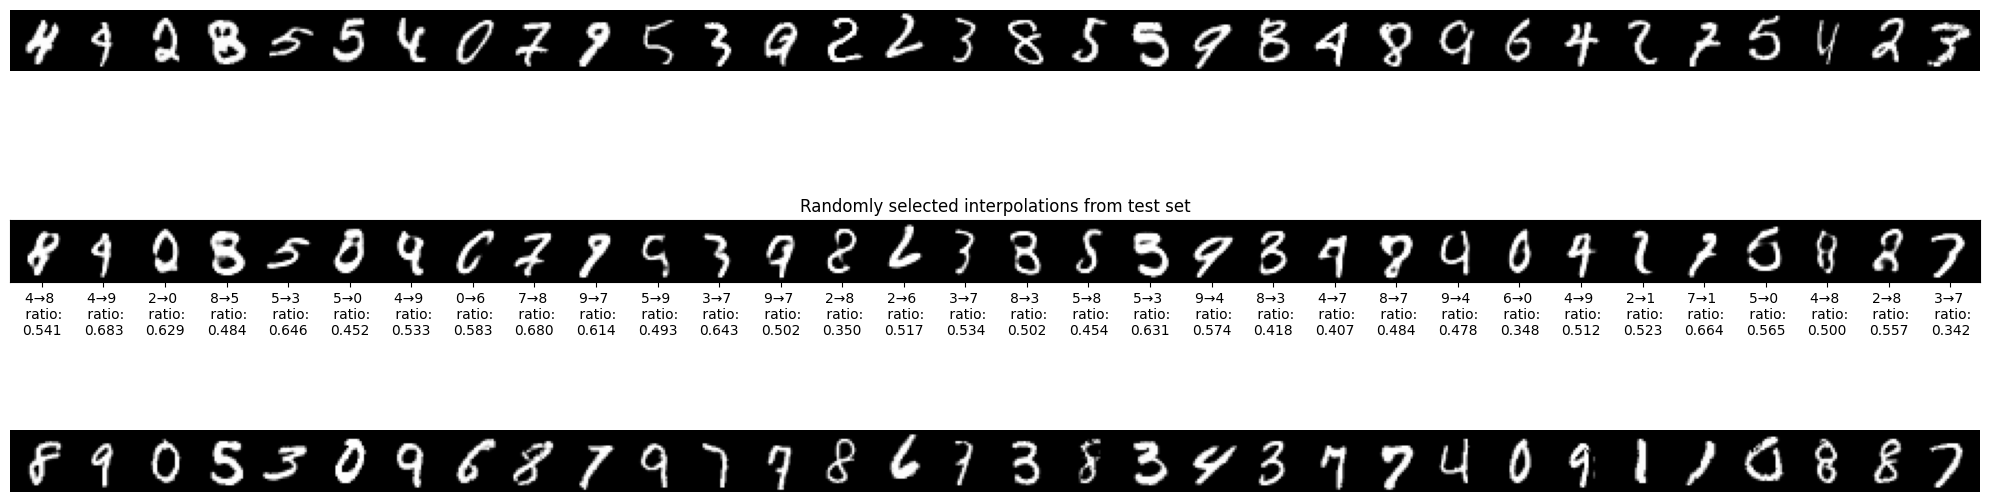

In [121]:
p = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist/interp_images.npy"
interp_images = np.load(p, allow_pickle=True).item()
print({k:v.shape for k,v in interp_images["train"].items()})
X_images = imu.get_MNIST_images()

n_random = 32
train = False
if train:
    interp_dict = interp_images["train"]
    X_images = X_images[:60000]
else:
    interp_dict = interp_images["test"]
    X_images = X_images[60000:]
N = len(interp_dict["gt_A"])
random_index = np.random.choice(N, size=n_random, replace=False)
images = interp_dict["interp_images"][random_index,0]
gt_A = interp_dict["gt_A"][random_index]
gt_B = interp_dict["gt_B"][random_index]
indices_A = interp_dict["indices_A"][random_index]
indices_B = interp_dict["indices_B"][random_index]
ratio_A = interp_dict["ratio_A"][random_index]


concat_image = np.concatenate([images[i] for i in range(n_random)], axis=1)
concat_xA = np.concatenate([X_images[indices_A[i]] for i in range(n_random)], axis=1)
concat_xB = np.concatenate([X_images[indices_B[i]] for i in range(n_random)], axis=1)
plt.figure(figsize=(20,7))

plt.subplot(3,1,1)
plt.imshow(concat_xA, cmap='gray')
plt.axis('off')

plt.subplot(3,1,2)
plt.imshow(concat_image, cmap='gray')
xticks = [f"{gt_A[i]}→{gt_B[i]} \n ratio:\n{ratio_A[i]:.3f}" for i in range(n_random)]
plt.xticks(ticks=np.arange(n_random)*28 + 14, labels=xticks)
plt.yticks([])
plt.title("Randomly selected interpolations from training set" if train else "Randomly selected interpolations from test set")

plt.subplot(3,1,3)
plt.imshow(concat_xB, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [105]:
len(interp_dict["gt_B"])

25000

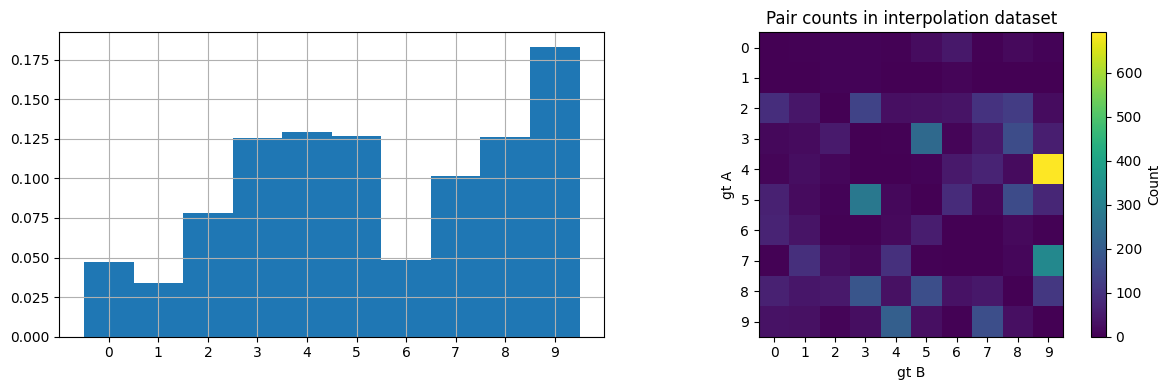

In [122]:
#gts of new points distribution
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(interp_dict["gt_B"].tolist()+interp_dict["gt_A"].tolist(), bins=np.arange(11)-0.5, density=True)
plt.xticks(ticks=np.arange(10), labels=[str(i) for i in range(10)])
plt.grid()
#gts of pairs matrix
plt.subplot(1,2,2)
count_mat = np.histogram2d(interp_dict["gt_A"], interp_dict["gt_B"], bins=np.arange(11)-0.5)[0]
plt.imshow(count_mat, vmin=0)
plt.colorbar(label="Count")
plt.xticks(ticks=np.arange(10), labels=[str(i) for i in range(10)])
plt.yticks(ticks=np.arange(10), labels=[str(i) for i in range(10)])
plt.xlabel("gt B")
plt.ylabel("gt A")
plt.title("Pair counts in interpolation dataset")
plt.tight_layout()
plt.show()


In [ ]:
#linear mapping that puts 0.25 -> 0.05 and 0.75 -> 0.95
amb_map = lambda p: np.clip(0.9*(p-0.25)/0.5 + 0.05,0,1)
plt.plot(np.linspace(0,1,100), amb_map(np.linspace(0,1,100)))

plt.grid()
plt.xlabel("Original ratio")
plt.ylabel("Mapped ratio")

TypeError: clamp() received an invalid combination of arguments - got (numpy.ndarray, int, int), but expected one of:
 * (Tensor input, Tensor min = None, Tensor max = None, *, Tensor out = None)
 * (Tensor input, Number min = None, Number max = None, *, Tensor out = None)


Sampling Indices from VAE Latents:   0%|          | 0/1000 [00:00<?, ?it/s]

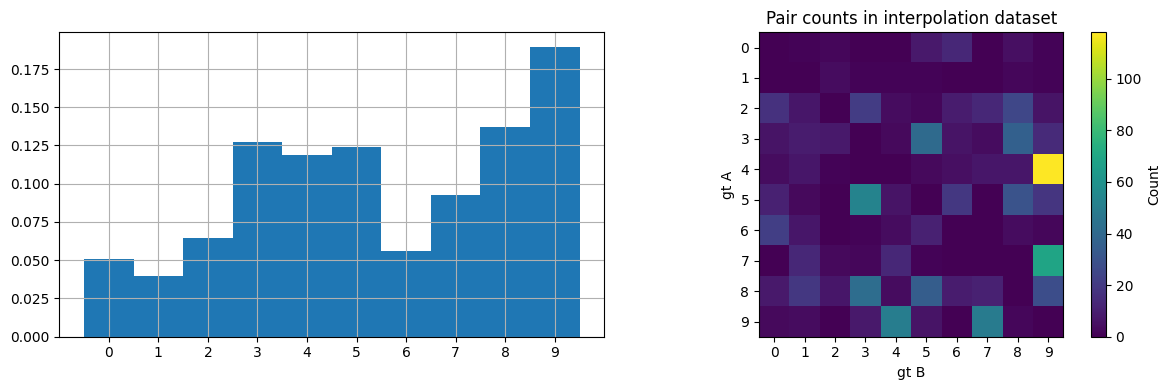

In [119]:
indices = imu.sample_from_vae_latents("train", save_dict["train_labels"],num_samples=1000)
idx_A = indices[:,0]
idx_B = indices[:,1]

gt_A = save_dict["train_labels"][idx_A].numpy()
gt_B = save_dict["train_labels"][idx_B].numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(gt_B.tolist()+gt_A.tolist(), bins=np.arange(11)-0.5, density=True)
plt.xticks(ticks=np.arange(10), labels=[str(i) for i in range(10)])
plt.grid()
#gts of pairs matrix
plt.subplot(1,2,2)
count_mat = np.histogram2d(gt_A, gt_B, bins=np.arange(11)-0.5)[0]
plt.imshow(count_mat, vmin=0)
plt.colorbar(label="Count")
plt.xticks(ticks=np.arange(10), labels=[str(i) for i in range(10)])
plt.yticks(ticks=np.arange(10), labels=[str(i) for i in range(10)])
plt.xlabel("gt B")
plt.ylabel("gt A")
plt.title("Pair counts in interpolation dataset")
plt.tight_layout()
plt.show()


In [116]:
uq,counts = np.unique(interp_dict["indices_A"].tolist()+interp_dict["indices_B"].tolist(), return_counts=True)
print(f"Average counts per index: {counts.mean():.1f}, min: {counts.min()}, max: {counts.max()}")

Average counts per index: 2.0, min: 1, max: 18


In [110]:
count_mat.astype(int)

array([[   0,   14,   53,   58,   23,  152,  232,   15,  107,   51],
       [   6,    0,   77,   34,   16,   10,   28,   25,   38,   37],
       [ 436,  377,    0,  622,  165,  117,  194,  379,  577,  148],
       [ 125,  196,  237,    0,   34, 1042,   87,  188,  862,  343],
       [  67,  137,   83,   10,    0,   55,  163,  434,   77, 3306],
       [ 330,  108,   28, 1236,  117,    0,  423,   58,  836,  365],
       [ 337,  181,   25,   15,   80,  252,    0,    1,   92,   14],
       [  42,  287,   79,   78,  419,   38,    3,    0,   66, 1648],
       [ 211,  391,  166,  894,  168,  753,  184,  151,    0,  537],
       [  88,  111,   53,  159, 1326,   69,   17,  981,  146,    0]])

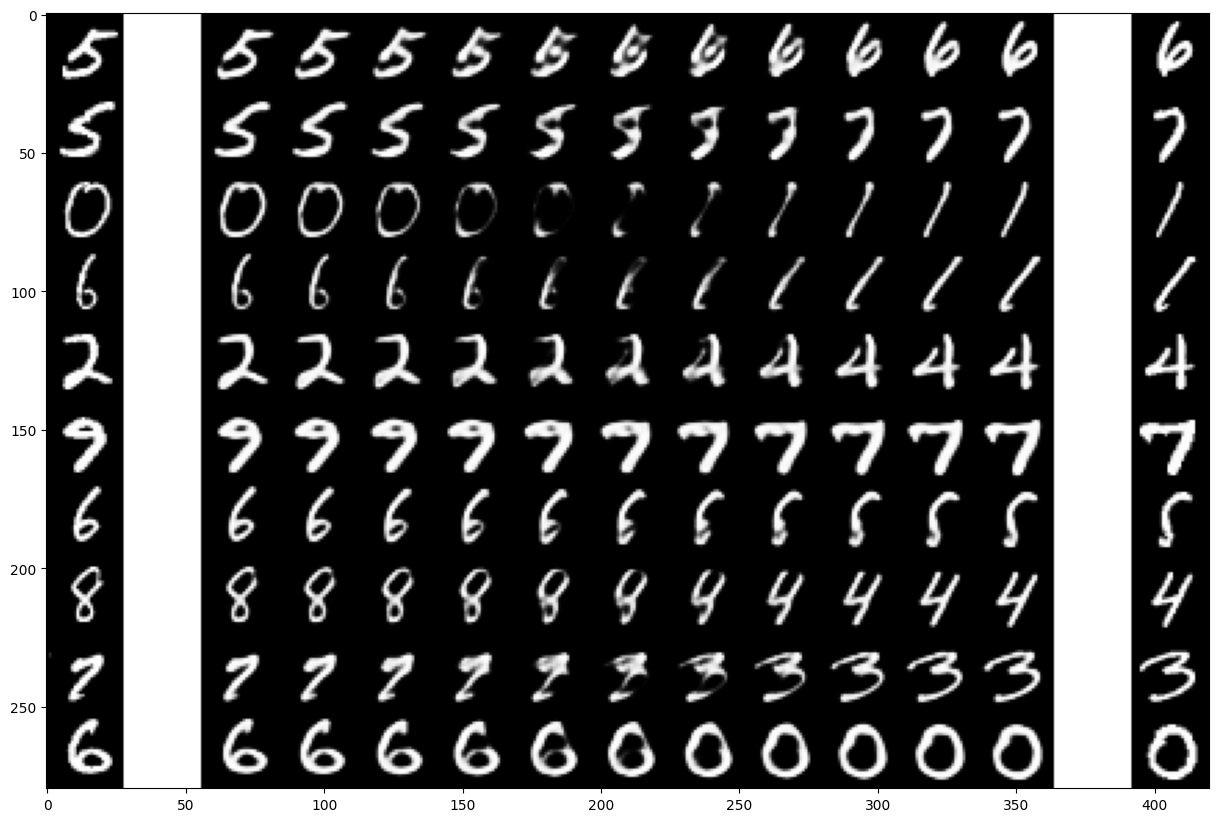

In [97]:
#interp
p = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist/interp_images_vae_neighbours.npy"
interp_dict = np.load(p, allow_pickle=True).item()["test"]
random_index = np.random.choice(len(interp_dict["indices_A"]), size=16, replace=False)
interp_idx_A = interp_dict["indices_A"][random_index]
interp_idx_B = interp_dict["indices_B"][random_index]
white_im = np.ones((28,28))
big_cat_image = []
for i in range(len(interp_idx_A[:10])):
    xA_np = X_images[interp_idx_A[i].astype(int)]
    xB_np = X_images[interp_idx_B[i].astype(int)]
    xA = torch.as_tensor(xA_np)[None,None]
    xB = torch.as_tensor(xB_np)[None,None]
    interp = imu.latent_interpolation(xA,xB)
    big_cat_image.append([xA_np]+[white_im]+interp+[white_im]+[xB_np])
big_cat_image = np.concatenate([np.concatenate(row, axis=1) for row in big_cat_image], axis=0)
plt.figure(figsize=(15,15))
plt.imshow(big_cat_image, cmap='gray')

/home/jloch/miniconda3/envs/sam3-env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.001s...
[t-SNE] Computed neighbors for 100000 samples in 5.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probabi

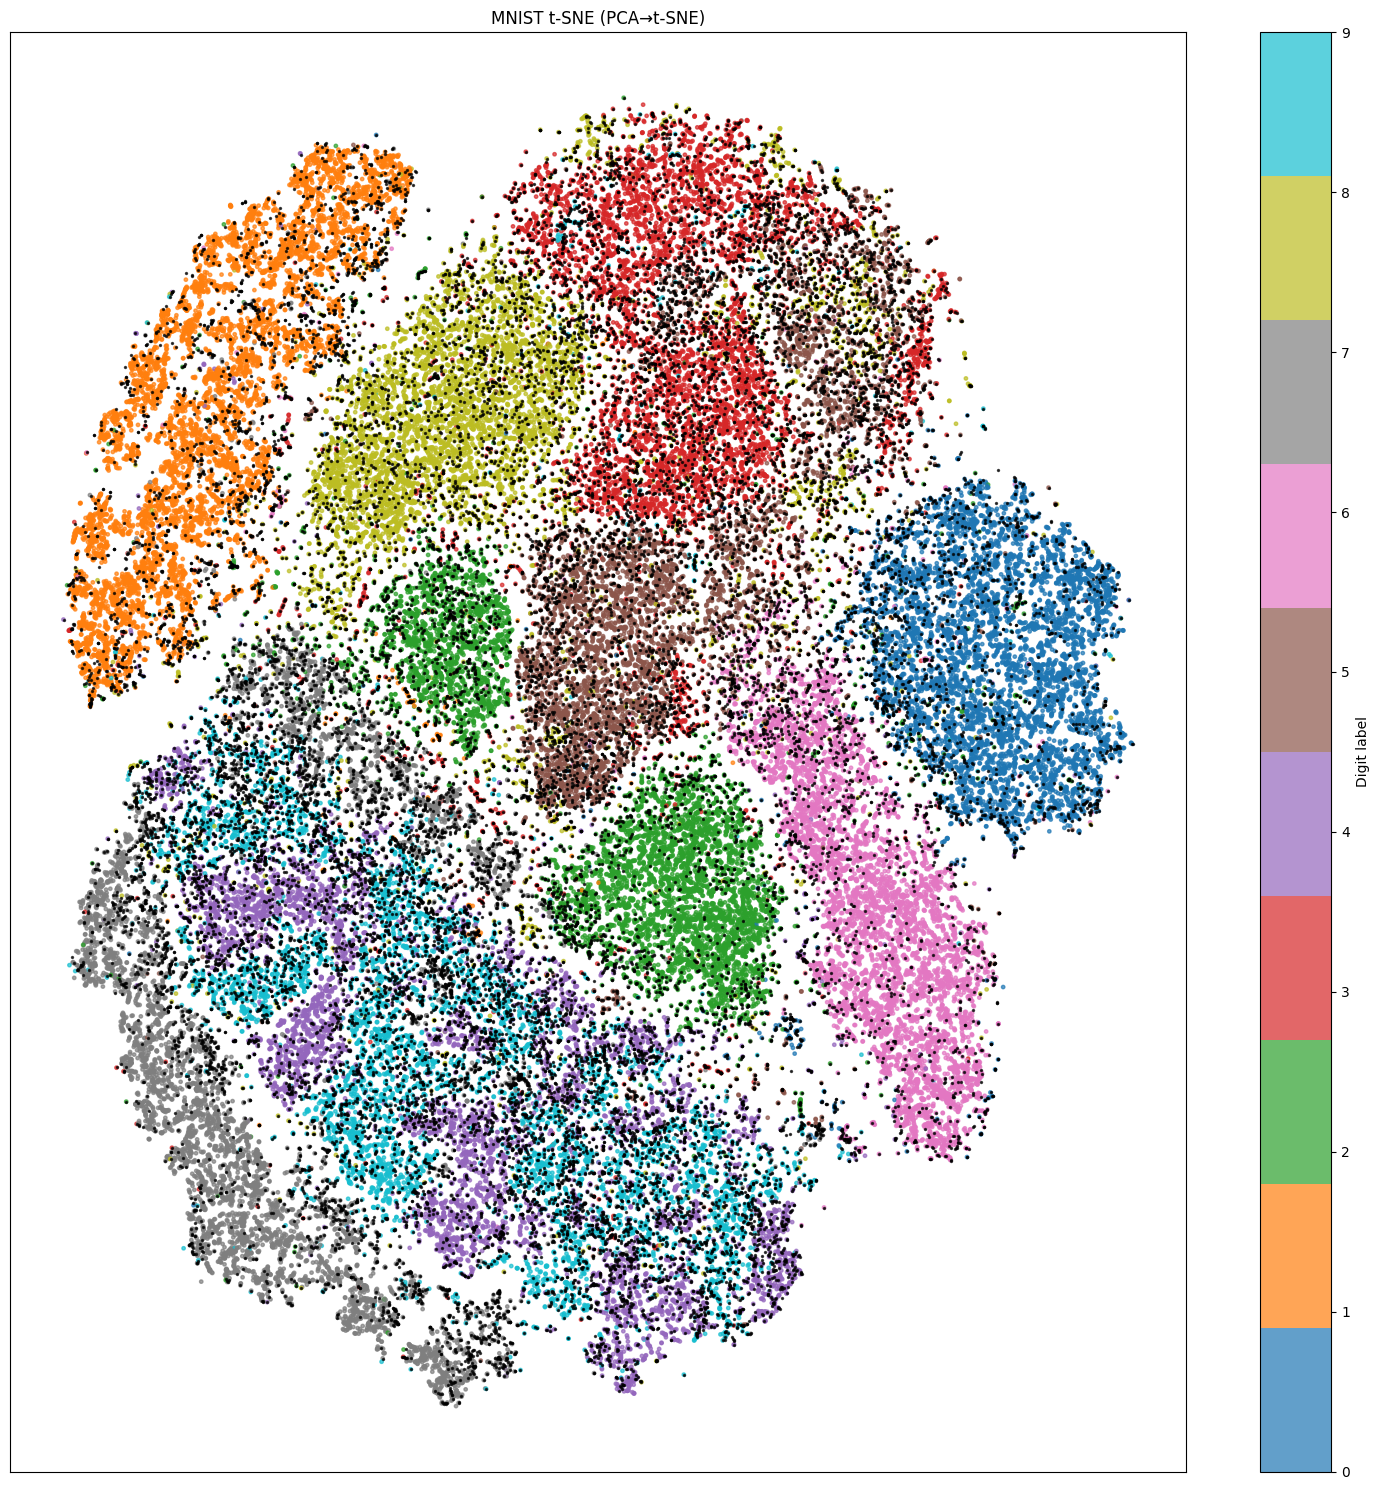

In [93]:
#compute t-SNE with new points
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# ----- config -----
pca_dim = 50
perplexity = 30
random_state = 1


p = "/home/jloch/Desktop/diff/luzern/values_datasets/mnist/interp_images_vae_neighbours.npy"
interp_images = np.load(p, allow_pickle=True).item()
X_images = imu.get_MNIST_images()
X_images = np.concatenate([X_images, interp_images["train"]["interp_images"][:,0], interp_images["test"]["interp_images"][:,0]], axis=0)
X = X_images.reshape((X_images.shape[0], -1))

# ----- PCA (helps t-SNE speed/stability) -----
X_pca = PCA(n_components=pca_dim, random_state=random_state).fit_transform(X)

# ----- t-SNE to 2D -----
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    learning_rate="auto",
    init="pca",
    n_iter=1000,
    random_state=random_state,
    verbose=1,
)
X_2d = tsne.fit_transform(X_pca)

# ----- plot -----
plt.figure(figsize=(15,15))
scatter = plt.scatter(X_2d[:70000, 0], X_2d[:70000, 1], c=y[:70000], s=6, alpha=0.7, cmap="tab10")
plt.scatter(X_2d[70000:, 0], X_2d[70000:, 1], c='black', s=2, alpha=0.7, label='interp')
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label("Digit label")
plt.title("MNIST t-SNE (PCA→t-SNE)")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()


In [ ]:
# plot new points in tsne space
plt.figure(figsize=(15,15))
scatter = plt.scatter(X_2d[:70000, 0], X_2d[:70000, 1], c=y[:70000], s=6, alpha=0.7, cmap="tab10")
plt.scatter(X_2d[70000:, 0], X_2d[70000:, 1], c='black', s=2, alpha=0.7, label='interp')
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label("Digit label")
plt.title("MNIST t-SNE (PCA→t-SNE)")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()
